In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
import sys
import os
sys.path.append('/Users/vs/Dropbox/Python')

### From Gaia documentation to do command line requests to Gaia DR1 archive
import httplib
import urllib
import time
from xml.dom.minidom import parseString

sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette(sns.husl_palette(10, l=.4))
colors = sns.color_palette()


//anaconda/envs/astroconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# variable_star_visualisation

** 
Notebook to visualise variable star photometry from the Gaia DR1 data release**

Vicky Scowcroft

Last update: October 19th 2016

## run_gaia_query 
* runs querys on the gaia archive using 


In [2]:
def run_gaia_query(adql_query, outputFileName):
    host = "gea.esac.esa.int"
    port = 80
    pathinfo = "/tap-server/tap/async"
    headers = {"Content-type": "application/x-www-form-urlencoded", "Accept":       "text/plain"}
    params = urllib.urlencode({"REQUEST": "doQuery", "LANG": "ADQL", "FORMAT": "csv", "PHASE":  "RUN", "QUERY": adql_query})

    connection = httplib.HTTPConnection(host, port)
    connection.request("POST",pathinfo,params,headers)

    #Status
    response = connection.getresponse()
    print "Status: " +str(response.status), "Reason: " + str(response.reason)

    #Server job location (URL)
    location = response.getheader("location")
    print "Location: " + location

    #Jobid
    jobid = location[location.rfind('/')+1:]
    print "Job id: " + jobid

    connection.close()

    #-------------------------------------
    #Check job status, wait until finished

    while True:
        connection = httplib.HTTPConnection(host, port)
        connection.request("GET",pathinfo+"/"+jobid)
        response = connection.getresponse()
        data = response.read()
        #XML response: parse it to obtain the current status
        dom = parseString(data)
        phaseElement = dom.getElementsByTagName('uws:phase')[0]
        phaseValueElement = phaseElement.firstChild
        phase = phaseValueElement.toxml()
        print "Status: " + phase
        #Check finished
        if phase == 'COMPLETED': break
        #wait and repeat
        time.sleep(0.2)

    #print "Data:"
    #print data

    connection.close()

    #-------------------------------------
    #Get results
    connection = httplib.HTTPConnection(host, port)
    connection.request("GET",pathinfo+"/"+jobid+"/results/result")
    response = connection.getresponse()
    data = response.read()
    outputFile = open(outputFileName, "w")
    outputFile.write(data)
    outputFile.close()
    connection.close()
    print "Data saved in: " + outputFileName
    return(0)



In [121]:
adql_query = "SELECT * FROM gaiadr1.variable_summary WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE'))"
run_gaia_query(adql_query, 'variable_stars.csv')

adql_query = "SELECT * FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE')"
run_gaia_query(adql_query, 'variable_stars_sourceinfo.csv')


Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476378622401O
Job id: 1476378622401O
Status: EXECUTING
Status: EXECUTING
Status: COMPLETED
Data saved in: variable_stars.csv
Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476378623557O
Job id: 1476378623557O
Status: EXECUTING
Status: EXECUTING
Status: COMPLETED
Data saved in: variable_stars_sourceinfo.csv


0

In [22]:
adql_query = "SELECT * FROM gaiadr1.tmass_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE'))"
run_gaia_query(adql_query, 'variable_stars_2mass.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476800958285O
Job id: 1476800958285O
Status: COMPLETED
Data saved in: variable_stars_2mass.csv


0

In [14]:
adql_query = "SELECT * from gaiadr1.tmass_original_valid WHERE tmass_oid IN (SELECT tmass_oid FROM gaiadr1.tmass_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE')))"

run_gaia_query(adql_query, 'variable_stars_2mass_photometry.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476800450156O
Job id: 1476800450156O
Status: COMPLETED
Data saved in: variable_stars_2mass_photometry.csv


0

In [6]:
variables_df = pd.read_csv('variable_stars.csv', header=0, sep=',')
variables_extended = pd.read_csv('variable_stars_sourceinfo.csv', header=0, sep=',')

variables_df = variables_df.merge(variables_extended, on='source_id')
variables_df = variables_df.rename(columns={'solution_id_x':'solution_id_var', 'solution_id_y': 'solution_id_source'})
variables_df['Period'] = variables_df.apply(lambda x: 1./x.phot_variable_fundam_freq1, axis=1)
useful = ['source_id', 'classification', 'Period', 'ra', 'dec', 'l', 'b', 'parallax', 'parallax_error', 'phot_g_mean_mag']

In [7]:
### Now grab the photometry for one of these stars
grabstar = np.random.randint(len(variables_df))
star_id = variables_df.source_id[grabstar]

adql_query = "SELECT * FROM gaiadr1.phot_variable_time_series_gfov  WHERE (source_id={0})".format(star_id)
phot_filename = 'phot_files/' + str(star_id) + '_phot.csv'
run_gaia_query(adql_query, phot_filename)

period = variables_df.ix[variables_df.source_id==star_id, 'Period'].values[0]
phot_df = pd.read_csv(phot_filename, header=0, sep=',')
phot_df['BJD'] = phot_df.apply(lambda x: x.observation_time + 2455197.5, axis=1)
phot_df['g_mag_err'] = phot_df.apply(lambda x: 1.086*x.g_flux_error/x.g_flux, axis=1)
phot_df['Phase'] = phot_df.apply(lambda x: ((x.BJD/ period) - np.floor(x.BJD / period)), axis=1)


Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476799081818O
Job id: 1476799081818O
Status: COMPLETED
Data saved in: phot_files/5284101734612101376_phot.csv


,source_id,classification,Period,ra,dec,l,b,parallax,parallax_error,phot_g_mean_mag
2634,5284101734612101376,RRLYR,0.631841,94.779111,-66.18409,276.040497,-27.88318,NaN,NaN,19.137771


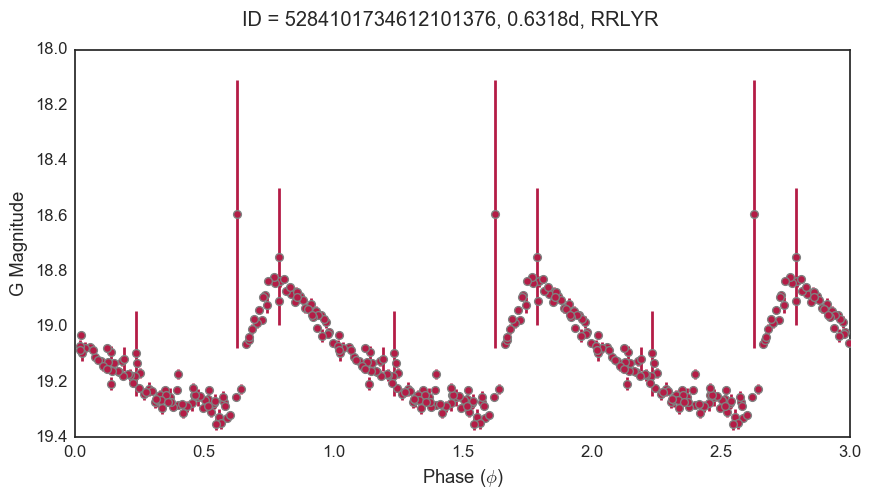

In [10]:
mp.clf()
mp.figure(figsize=(10,5))
mp.errorbar(np.concatenate((phot_df.Phase, phot_df.Phase + 1.0, phot_df.Phase + 2.0)) , np.concatenate((phot_df.g_magnitude, phot_df.g_magnitude, phot_df.g_magnitude)), yerr = np.concatenate((phot_df.g_mag_err, phot_df.g_mag_err, phot_df.g_mag_err)), ls='None',zorder=4, color=colors[0], label='_nolegend_')
mp.plot(np.concatenate((phot_df.Phase, phot_df.Phase + 1.0, phot_df.Phase + 2.0)) , np.concatenate((phot_df.g_magnitude, phot_df.g_magnitude, phot_df.g_magnitude)), 'o', color=colors[0], ls='None', zorder=4, markeredgecolor='Grey', markeredgewidth=1, label='G')
mp.gca().invert_yaxis()
mp.xlabel('Phase ($\phi$)')
mp.ylabel('G Magnitude')
titletext = 'ID = ' + str(star_id) + ', ' + str(np.around(period, decimals=4)) + 'd, ' + variables_df.ix[variables_df.source_id==star_id, 'classification'].values[0]
mp.suptitle(titletext)
variables_df.ix[variables_df.source_id==star_id, useful]

# Other photometry of variable stars:


# 2mass

In [15]:
adql_query = "SELECT * from gaiadr1.tmass_original_valid WHERE tmass_oid IN (SELECT tmass_oid FROM gaiadr1.tmass_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE')))"

run_gaia_query(adql_query, 'variable_stars_2mass_photometry.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476800497918O
Job id: 1476800497918O
Status: COMPLETED
Data saved in: variable_stars_2mass_photometry.csv


0

In [23]:
adql_query = "SELECT * FROM gaiadr1.tmass_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE'))"
run_gaia_query(adql_query, 'variable_stars_2mass.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476800976198O
Job id: 1476800976198O
Status: COMPLETED
Data saved in: variable_stars_2mass.csv


0

# SDSS DR9


HAHA none in SDSS because it's in the NORTH.

ONE DAY I WILL LEARN

In [18]:
adql_query = "SELECT * from gaiadr1.sdssdr9_original_valid WHERE sdssdr9_oid IN (SELECT sdssdr9_oid FROM gaiadr1.sdss_dr9_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE')))"

run_gaia_query(adql_query, 'variable_stars_sdss_dr9_photometry.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476800713149O
Job id: 1476800713149O
Status: COMPLETED
Data saved in: variable_stars_sdss_dr9_photometry.csv


0

In [24]:
adql_query = "SELECT * FROM gaiadr1.sdss_dr9_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE'))"
run_gaia_query(adql_query, 'variable_stars_sdss_dr9.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476801030416O
Job id: 1476801030416O
Status: COMPLETED
Data saved in: variable_stars_sdss_dr9.csv


0

# allWISE

In [19]:
adql_query = "SELECT * from gaiadr1.allwise_original_valid WHERE allwise_oid IN (SELECT allwise_oid FROM gaiadr1.allwise_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE')))"

run_gaia_query(adql_query, 'variable_stars_allwise_photometry.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476800831019O
Job id: 1476800831019O
Status: EXECUTING
Status: EXECUTING
Status: COMPLETED
Data saved in: variable_stars_allwise_photometry.csv


0

In [25]:
adql_query = "SELECT * FROM gaiadr1.allwise_best_neighbour WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE'))"
run_gaia_query(adql_query, 'variable_stars_allwise.csv')

Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476801057196O
Job id: 1476801057196O
Status: COMPLETED
Data saved in: variable_stars_allwise.csv


0

In [20]:
tmass_df = pd.read_csv('variable_stars_2mass_photometry.csv', header=0, sep=',')
sdss_df = pd.read_csv('variable_stars_sdss_dr9_photometry.csv', header=0, sep=',')
allwise_df = pd.read_csv('variable_stars_allwise_photometry.csv', header=0, sep=',')

In [27]:
tmass_df_var = pd.read_csv('variable_stars_2mass.csv',header=0, sep=',')
sdss_df_var = pd.read_csv('variable_stars_sdss_dr9.csv', header=0, sep=',')
allwise_df_var = pd.read_csv('variable_stars_allwise.csv', header=0, sep=',')

In [40]:
sdss_df_var.columns, sdss_df.columns

(Index([u'sdssdr9_oid', u'source_id', u'original_ext_source_id',
        u'angular_distance', u'number_of_neighbours', u'number_of_mates',
        u'best_neighbour_multiplicity', u'proper_motion_flag'],
       dtype='object'),
 Index([u'sdssdr9_oid', u'obj_id', u'thing_id', u'ra', u'dec', u'ra_error',
        u'dec_error', u'mjd', u'u_mag', u'u_mag_error', u'g_mag',
        u'g_mag_error', u'r_mag', u'r_mag_error', u'i_mag', u'i_mag_error',
        u'z_mag', u'z_mag_error', u'objc_type', u'clean_flag'],
       dtype='object'))

In [34]:
tmass_df = tmass_df.merge(tmass_df_var, on='tmass_oid')
sdss_df = sdss_df.merge(sdss_df_var, on='sdssdr9_oid')
allwise_df = allwise_df.merge(allwise_df_var, on='allwise_oid')


In [52]:
wise_df

,solution_id_var,source_id,phot_variable_fundam_freq1,classification,solution_id_source,random_index,ref_epoch,ra_x,ra_error_x,dec_x,...,w3gmag_error,w4gmag,w4gmag_error,tmass_key,original_ext_source_id,angular_distance,number_of_neighbours,number_of_mates,best_neighbour_multiplicity,proper_motion_flag
0,374678695396246029,4660670086080134912,0.365503,CEP,1635378410781933568,404444475,2015.0,83.991455,0.132550,-66.176324,...,NaN,NaN,NaN,8.082085e+08,J053557.91-661034.7,0.190365,1,0,1,0
1,374678695396246029,4675338120949840768,1.331094,RRLYR,1635378410781933568,312357441,2015.0,69.001326,0.081747,-64.399874,...,NaN,NaN,NaN,2.253756e+08,J043600.31-642359.4,0.100968,1,0,1,0
2,374678695396246029,4660538247763017344,0.456471,CEP,1635378410781933568,339915012,2015.0,81.241857,0.137079,-65.970325,...,NaN,NaN,NaN,8.530300e+08,J052458.02-655813.1,0.150030,1,0,1,0
3,374678695396246029,4663209992299609088,1.808844,RRLYR,1635378410781933568,92886307,2015.0,70.748155,0.131097,-65.314611,...,NaN,NaN,NaN,1.363379e+08,J044259.60-651852.7,0.361727,1,0,1,0
4,374678695396246029,4663197863313540736,3.339783,RRLYR,1635378410781933568,722598049,2015.0,70.736305,0.758499,-65.566606,...,NaN,NaN,NaN,NaN,J044256.56-653358.8,1.311871,1,0,1,0
5,374678695396246029,4659533431574807936,0.327474,CEP,1635378410781933568,402170445,2015.0,84.518070,0.090334,-66.593724,...,NaN,NaN,NaN,8.082806e+08,J053804.33-663537.4,0.041593,1,0,1,0
6,374678695396246029,4673212322590824064,1.449125,RRLYR,1635378410781933568,424470453,2015.0,58.399469,0.634068,-63.772366,...,NaN,NaN,NaN,NaN,J035335.89-634619.8,0.650171,1,0,1,0
7,374678695396246029,4659639053413432064,0.445571,CEP,1635378410781933568,550533920,2015.0,87.277961,0.086472,-67.026797,...,NaN,NaN,NaN,1.252908e+09,J054906.73-670136.4,0.164687,1,0,1,0
8,374678695396246029,4662677656874460032,1.979768,RRLYR,1635378410781933568,161469669,2015.0,70.186756,0.497933,-66.544933,...,NaN,NaN,NaN,NaN,J044044.90-663240.6,1.245978,1,0,1,0
9,374678695396246029,4662958822614225280,0.420666,CEP,1635378410781933568,5215937,2015.0,73.397167,0.124142,-65.830602,...,NaN,NaN,NaN,1.364509e+08,J045335.28-654950.0,0.245797,1,0,1,0


In [44]:
variables_df = variables_df.merge(allwise_df, on='source_id')


In [49]:
wise_df = variables_df[variables_df.w1gmag!=np.nan]

In [54]:
wise_df[wise_df.classification=='RRLYR']

,solution_id_var,source_id,phot_variable_fundam_freq1,classification,solution_id_source,random_index,ref_epoch,ra_x,ra_error_x,dec_x,...,w3gmag_error,w4gmag,w4gmag_error,tmass_key,original_ext_source_id,angular_distance,number_of_neighbours,number_of_mates,best_neighbour_multiplicity,proper_motion_flag
1,374678695396246029,4675338120949840768,1.331094,RRLYR,1635378410781933568,312357441,2015.0,69.001326,0.081747,-64.399874,...,NaN,NaN,NaN,225375551.0,J043600.31-642359.4,0.100968,1,0,1,0
3,374678695396246029,4663209992299609088,1.808844,RRLYR,1635378410781933568,92886307,2015.0,70.748155,0.131097,-65.314611,...,NaN,NaN,NaN,136337927.0,J044259.60-651852.7,0.361727,1,0,1,0
4,374678695396246029,4663197863313540736,3.339783,RRLYR,1635378410781933568,722598049,2015.0,70.736305,0.758499,-65.566606,...,NaN,NaN,NaN,NaN,J044256.56-653358.8,1.311871,1,0,1,0
6,374678695396246029,4673212322590824064,1.449125,RRLYR,1635378410781933568,424470453,2015.0,58.399469,0.634068,-63.772366,...,NaN,NaN,NaN,NaN,J035335.89-634619.8,0.650171,1,0,1,0
8,374678695396246029,4662677656874460032,1.979768,RRLYR,1635378410781933568,161469669,2015.0,70.186756,0.497933,-66.544933,...,NaN,NaN,NaN,NaN,J044044.90-663240.6,1.245978,1,0,1,0
10,374678695396246029,4677006011368736384,1.633397,RRLYR,1635378410781933568,987532799,2015.0,69.497943,0.555782,-63.219090,...,NaN,NaN,NaN,NaN,J043759.64-631308.2,1.054837,1,0,1,0
11,374678695396246029,4676957117461314432,2.074071,RRLYR,1635378410781933568,476589611,2015.0,63.487391,0.822590,-60.949368,...,NaN,NaN,NaN,NaN,J041357.05-605658.2,0.816911,1,0,1,0
13,374678695396246029,4663020086028882816,2.856579,RRLYR,1635378410781933568,40185232,2015.0,72.224531,0.481292,-65.669794,...,NaN,NaN,NaN,NaN,J044854.06-654011.4,1.143077,1,0,1,0
18,374678695396246029,4659803636559757056,1.567686,RRLYR,1635378410781933568,1119950461,2015.0,87.855825,0.527572,-66.060180,...,NaN,NaN,NaN,NaN,J055125.46-660337.2,0.728664,1,0,1,0
19,374678695396246029,4676532396735780608,1.895884,RRLYR,1635378410781933568,619461170,2015.0,64.291371,0.475553,-62.581138,...,NaN,NaN,NaN,NaN,J041709.84-623452.5,0.734054,1,0,1,0
